## Data Science Summer School - Split '17

## 5. Generating images of digits with Generative Adversarial Networks

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, util

## Goals:

1. Implement the model from "[Generative Adversarial Networks](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)" by Goodfellow et al. (1284 citations since 2014.)

2. **Understand** how the model learns to generate realistic images

In ~two hours.

## 5.1 Downloading the datasets and previewing data

In [3]:
data_folder = 'data'; dataset = 'mnist'  # the folder in which the dataset is going to be stored

download_folder = util.download_mnist(data_folder, dataset)
images, labels = util.load_mnist(download_folder)

print("Folder:", download_folder)
print("Image shape:", images.shape) # greyscale, so the last dimension (color channel) = 1
print("Label shape:", labels.shape) # one-hot encoded

Found mnist Data
Folder: data/mnist
Image shape: (70000, 28, 28, 1)
Label shape: (70000, 10)


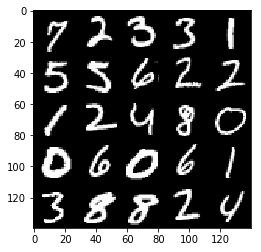

In [4]:
show_n_images = 25
sample_images, mode = util.get_sample_images(images, n=show_n_images)
mnist_sample = util.images_square_grid(sample_images, mode)
plt.imshow(mnist_sample, cmap='gray')

In [5]:
sample = images[3]*50 # 
sample = sample.reshape((28, 28))
print(np.array2string(sample.astype(int), max_line_width=100, separator=',', precision=0))

[[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,21,49,49,50,49,49,37,17, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 4,35,47,49,49,49,49,49,49,49,43, 9, 1, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 6,49,49,49,49,49,49,49,49,49,49,49,23, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 6,49,49,49,49,49,49,49,49,49,49,49,43, 9, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 6,49,49,49,49,49,26,25,34,49,49,49,49,43,10, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 6,49,49,49,47,20, 0, 0,15,39,44,49,49,49,20, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0,24,49,49,49,36, 0, 0, 0, 0, 0,22,49,49,49,36,19, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0,19,48,49,

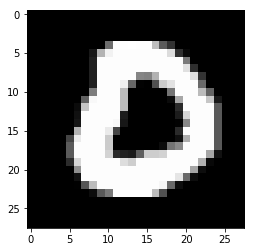

In [6]:
plt.imshow(sample, cmap='gray')

## What are we going to do with the data?

- We **have** $70000$ images of hand-written digits generated from some distribution $X \sim P_{real}$
- We **have** $70000$ labels $y_i \in \{0,..., 9\}$ indicating which digit is written on the image $x_i$

**Problem:** Imagine that the number of images we have **is not enough** - a common issue in computer vision and machine learning.

1. We can pay experts to create new images
  * **Expensive**
  * Slow
  * Realiable
2. We can generate new images ourselves
  * **Cheap**
  * **Fast**
  * Unreliable?

**Problem:** Not every image that we generate is going to be perfect (or even close to perfect). Therefore, we need some method to determine which images are realistic. 

1. We can pay experts to determine which images are good enough
  * Expensive
  * Slow
  * **Reliable**
2. We can train a model to determine which images are good enough
  * **Cheap**
  * **Fast**
  * Unreliable?

## Formalization

* $X \sim P_{real}$ : existing images of shape $s$
* $Z \sim P_z$ : a $k$-dimensional random vector
* $G(z; \theta_G): Z \to \hat{X}$ : the **generator**, a function that transforms the random vector $z$ into an image of shape $s$
* $D(x, \theta_D): X \to (Real, Fake)$ : the **discriminator** a function that given an image of shape $s$ decides if the image is real or fake

### Details

The existing images $X$ in our setup are images from the mnist dataset. We will arbitrarily decide that vectors $z$ will be sampled from a uniform distribution, and $G$ and $D$ will both be *'deep'* neural networks. 

For simplicity, and since we are using the mnist dataset, both $G$ and $D$ will be multi-layer perceptrons (and not deep convolutional networks) with one hidden layer. The generated images $G(z) \sim P_{fake}$ as well as real images $x \sim P_{real}$ will be passed on to the discriminator, which will classify them into $(Real, Fake)$.

<center>
<img src="data/img/gan_general_layout.png">
<strong>Figure 1. </strong> General adversarial network architecture
</center>

### Discriminator
** The goal ** of the discriminator is to successfully recognize which image is sampled from the true distribution, and which image is sampled from the generator. 

<center>
<img src="data/img/discriminator.png">
<strong>Figure 2.</strong> Discriminator network sketch
</center>

### Generator
** The goal ** of the generator is that the discriminator *missclassifies* the images that the generator generated as if they were generated by the true distribution.

<center>
<img src="data/img/generator.png">
<strong>Figure 3.</strong> Generator network sketch
</center>


## 5.2 Data transformation

Since we are going to use a fully connected network (we are not going to use local convolutional filters), we are going to flatten the input images for simplicity. Also, the pixel values are scaled to the interval $[0,1]$ (this was already done beforehand). 

We will also use a pre-made `Dataset` class to iterate over the dataset in batches. The class is defined in `util.py`, and only consists of a constructor and a method `next_batch`.

**Question:** Having seen the architecture of the network, why are we the pixels scaled to $[0,1]$ and not, for example, $[-1, 1]$, or left at $[0, 255]$?

**Answer:** 

In [7]:
# the mnist dataset is stored in the variable 'images', and the labels are stored in 'labels'
images = images.reshape(-1, 28*28) # 70000 x 784
print (images.shape, labels.shape) 

mnist = util.Dataset(images, labels)
print ("Number of samples:", mnist.n)

(70000, 784) (70000, 10)
Number of samples: 70000


## 5.3 The generator network

In [8]:
class Generator:
    """The generator network
    
    the generator network takes as input a vector z of dimension input_dim, and transforms it 
    to a vector of size output_dim. The network has one hidden layer of size hidden_dim.
    
    We will define the following methods: 
    
    __init__: initializes all variables by using tf.get_variable(...) 
                and stores them to the class, as well a list in self.theta
    forward: defines the forward pass of the network - how do the variables
                interact with respect to the inputs
    """
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        """Constructor for the generator network. In the constructor, we will
        just initialize all the variables in the network.
        
        Args:
            input_dim: The dimension of the input data vector (z).
            hidden_dim: The dimension of the hidden layer of the neural network (h)
            output_dim: The dimension of the output layer (equivalent to the size of the image)            
            
        """
        
        with tf.variable_scope("generator"):
            self.W1 = tf.get_variable(name="W1", 
                                      shape=[input_dim, hidden_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b1 = tf.get_variable(name="b1", 
                                      shape=[hidden_dim], 
                                      initializer=tf.zeros_initializer())
            
            self.W2 = tf.get_variable(name="W2", 
                                      shape=[hidden_dim, output_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b2 = tf.get_variable(name="b2", 
                                      shape=[output_dim], 
                                      initializer=tf.zeros_initializer())

            self.theta = [self.W1, self.W2, self.b1, self.b2]
    
    def forward(self, z):
        """The forward pass of the network -- here we will define the logic of how we combine
        the variables through multiplication and activation functions in order to get the
        output.
        
        """
        h1 = tf.nn.relu(tf.matmul(z, self.W1) + self.b1)
        
        log_prob = tf.matmul(h1, self.W2) + self.b2
        prob = tf.nn.sigmoid(log_prob)

        return prob


## 5.4 The basic network for the discriminator

In [9]:
class Discriminator:
    """The discriminator network
    
    the discriminator network takes as input a vector x of dimension input_dim, and transforms it 
    to a vector of size output_dim. The network has one hidden layer of size hidden_dim.
    
    You will define the following methods: 
    
    __init__: initializes all variables by using tf.get_variable(...) 
                and stores them to the class, as well a list in self.theta
    forward: defines the forward pass of the network - how do the variables
                interact with respect to the inputs
    """
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        with tf.variable_scope("discriminator"):
            
            self.W1 = tf.get_variable(name="W1", 
                                      shape=[input_dim, hidden_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b1 = tf.get_variable(name="b1", shape=[hidden_dim], 
                                      initializer=tf.zeros_initializer())
            
            self.W2 = tf.get_variable(name="W2", 
                                      shape=[hidden_dim, output_dim], 
                                      initializer=tf.contrib.layers.xavier_initializer())
            self.b2 = tf.get_variable(name="b2", 
                                      shape=[output_dim], 
                                      initializer=tf.zeros_initializer())

            self.theta = [self.W1, self.W2, self.b1, self.b2]
    
    def forward(self, x):
        """The forward pass of the network -- here we will define the logic of how we combine
        the variables through multiplication and activation functions in order to get the
        output.
        
        """
        h1 = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
        logit = tf.matmul(h1, self.W2) + self.b2
        prob = tf.nn.sigmoid(logit)

        return prob, logit


### Intermezzo: Xavier initialization of weights

Glorot, X., & Bengio, Y. (2010, March). [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). In Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics (pp. 249-256).

Implemented in tensorflow, as part of the standard library: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer

#### 1. Idea:

- If the weights in a network are initialized to too small values, then the signal shrinks as it passes through each layer until it’s too tiny to be useful.
- If the weights in a network are initialized to too large, then the signal grows as it passes through each layer until it’s too massive to be useful.

#### 2. Goal: 

- We need initial weight values that are *just right* for the signal not to explode or vanish during the forward pass

#### 3. Math

- Trivial

#### 4. Solution

- $v = \frac{2}{n_{in} + n_{out}}$

In the case of a Gaussian distribution, we set the **variance** to $v$.

In the case of a uniform distribution, we set the **interval ** to $\pm v$ (the default distr. in tensorflow is the uniform).

<sub>http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization</sub>


## 5.5 Define the model parameters

We will take a brief break to set the values for the parameters of the model. Since we know the dataset we are working with, as well as the shape of the generator and discriminator networks, your task is to fill in the values of the following variables.

In [10]:
image_dim = 784 # The dimension of the input image vector to the discrminator
discriminator_hidden_dim = 128 # The dimension of the hidden layer of the discriminator
discriminator_output_dim = 1 # The dimension of the output layer of the discriminator 

random_sample_dim = 100 # The dimension of the random noise vector z
generator_hidden_dim = 128 # The dimension of the hidden layer of the generator
generator_output_dim = 784 # The dimension of the output layer of the generator

## 5.6 Check the implementation of the classes


In [11]:
d = Discriminator(image_dim, discriminator_hidden_dim, discriminator_output_dim)
for param in d.theta:
    print (param)

<tf.Variable 'discriminator/W1:0' shape=(784, 128) dtype=float32_ref>
<tf.Variable 'discriminator/W2:0' shape=(128, 1) dtype=float32_ref>
<tf.Variable 'discriminator/b1:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'discriminator/b2:0' shape=(1,) dtype=float32_ref>


In [12]:
g = Generator(random_sample_dim, generator_hidden_dim, generator_output_dim)
for param in g.theta:
    print (param)

<tf.Variable 'generator/W1:0' shape=(100, 128) dtype=float32_ref>
<tf.Variable 'generator/W2:0' shape=(128, 784) dtype=float32_ref>
<tf.Variable 'generator/b1:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'generator/b2:0' shape=(784,) dtype=float32_ref>


### Drawing samples from the latent space

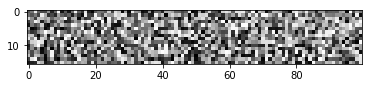

In [13]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

plt.imshow(sample_Z(16, 100), cmap='gray')

## 5.5 Define the model loss -- Vanilla GAN

The objective for the vanilla version of the GAN was defined as follows:

<center>
$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{real}} [log(D(x))] + \mathbb{E}_{z \sim p_{z}} [log(1 -D(G(z)))]$
</center>

The function contains a *minimax* formulation, and cannot be directly optimized. However, if we freeze $D$, we can derive the loss for $G$ and vice versa.

**Discriminator loss:**
<center>
$p_{fake} = G(p_z)$
</center>

<center>
$D_{loss} = \mathbb{E}_{x \sim p_{real}} [log(D(x))] + \mathbb{E}_{\hat{x} \sim p_{fake}} [log(1 -D(\hat{x}))]$
</center>

We estimate the expectation over each minibatch and arrive to the following formulation:
<center>
$D_{loss} = \frac{1}{m}\sum_{i=0}^{m} log(D(x_i)) + \frac{1}{m}\sum_{i=0}^{m} log(1 -D(\hat{x_i}))$
</center>


**Generator loss:**
<center>
$G_{loss} = - \mathbb{E}_{z \sim p_{z}} [log(1 -D(G(z)))]$
</center>

<center>
$G_{loss} = \frac{1}{m}\sum_{i=0}^{m} [log(D(G(z)))]$
</center>


### Model loss, translated from math

The **discriminator** wants to:
- **maximize** the (log) probability of a **real** image being classified as **real**,
- **minimize** the (log) probability of a **fake** image being classified as **real**.

The **generator** wants to:
- **maximize** the (log) probability of a **fake** image being classified as **real**.

### Model loss, translated to practical machine learning

The output of the discriminator is a scalar, $p$, which we interpret as the probability that an input image is **real** ($1-p$ is the probability that the image is fake).

The **discriminator** takes as input:

- a minibatch of images from our training set with a vector of **ones** for class labels: $D_{loss\_real}$. 
- a minibatch of images from the generator with a vector of **zeros** for class labels: $D_{loss\_fake}$.  
- a minibatch of images from the generator with a vector of **ones** for class labels: $G_{loss}$.

The **generator** takes as input:

- a minibatch of vectors sampled from the latent space and transforms them to a minibatch of generated images

In [14]:
def gan_model_loss(X, Z, discriminator, generator):
    G_sample = g.forward(Z)
    D_real, D_logit_real = d.forward(X)
    D_fake, D_logit_fake = d.forward(G_sample)

    D_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))

    D_loss = D_loss_real + D_loss_fake

    G_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

    return G_sample, D_loss, G_loss
    

### Intermezzo: sigmoid cross entropy with logits

We defined the loss of the model as the log of the probability, but we are not using a $log$ function or the model probablities anywhere?

Enter sigmoid cross entropy with logits: https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

<center>
<img src="data/img/logitce.png">
From the tensorflow documentation
</center>

### Putting it all together

In [15]:
X = tf.placeholder(tf.float32, name="input", shape=[None, image_dim])
Z = tf.placeholder(tf.float32, name="latent_sample", shape=[None, random_sample_dim])

G_sample, D_loss, G_loss = gan_model_loss(X, Z, d, g)

with tf.variable_scope('optim'):
    D_solver = tf.train.AdamOptimizer(name='discriminator').minimize(D_loss, var_list=d.theta)
    G_solver = tf.train.AdamOptimizer(name='generator').minimize(G_loss, var_list=g.theta)

In [36]:
saver = tf.train.Saver()

# Some runtime parameters predefined for you
minibatch_size = 128 # The size of the minibatch

num_epoch = 500 # For how many epochs do we run the training
plot_every_epochs = 5 # After this many epochs we will save & display samples of generated images 
print_every_batches = 1000 # After this many minibatches we will print the losses

restore = False
checkpoint = 'fc_2layer_e100_2.170.ckpt'
model = 'gan'
model_save_folder = os.path.join('data', 'chkp', model)
print ("Model checkpoints will be saved to:", model_save_folder)
image_save_folder = os.path.join('data', 'model_output', model)
print ("Image samples will be saved to:", image_save_folder)

Model checkpoints will be saved to: data/chkp/gan
Image samples will be saved to: data/model_output/gan


Epoch: 0/500
Iter: 256/70000
Discriminator loss: 1.354
Generator loss: 2.528



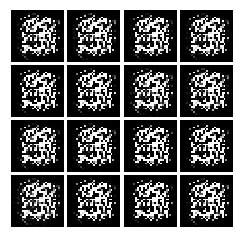

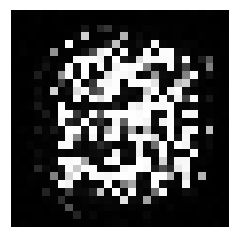

Epoch: 1/500
Iter: 58368/70000
Discriminator loss: 0.007699
Generator loss: 8.272

Epoch: 3/500
Iter: 46592/70000
Discriminator loss: 0.05098
Generator loss: 6.63

Epoch: 5/500
Iter: 34816/70000
Discriminator loss: 0.06567
Generator loss: 6.246



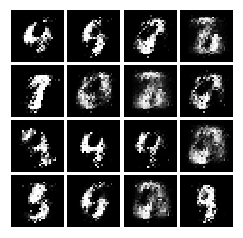

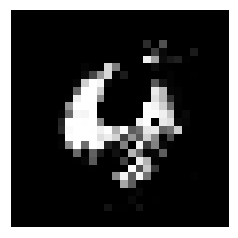

Epoch: 7/500
Iter: 23040/70000
Discriminator loss: 0.1248
Generator loss: 5.585

Epoch: 9/500
Iter: 11264/70000
Discriminator loss: 0.1748
Generator loss: 4.627

Epoch: 10/500
Iter: 69376/70000
Discriminator loss: 0.223
Generator loss: 5.761



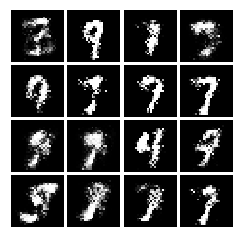

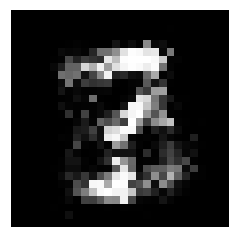

Epoch: 12/500
Iter: 57600/70000
Discriminator loss: 0.277
Generator loss: 4.785

Epoch: 14/500
Iter: 45824/70000
Discriminator loss: 0.7368
Generator loss: 2.833



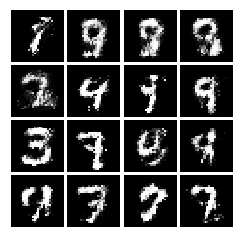

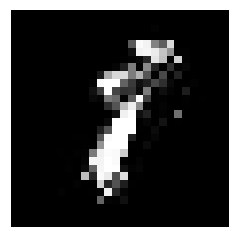

Epoch: 16/500
Iter: 34048/70000
Discriminator loss: 0.233
Generator loss: 3.799

Epoch: 18/500
Iter: 22272/70000
Discriminator loss: 0.4853
Generator loss: 3.508

Epoch: 20/500
Iter: 10496/70000
Discriminator loss: 0.5507
Generator loss: 3.203



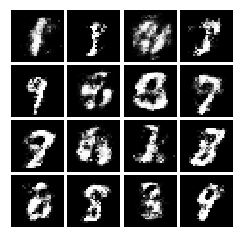

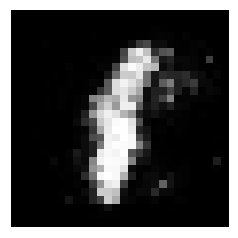

Epoch: 21/500
Iter: 68608/70000
Discriminator loss: 0.538
Generator loss: 2.852

Epoch: 23/500
Iter: 56832/70000
Discriminator loss: 0.6897
Generator loss: 2.946

Epoch: 25/500
Iter: 45056/70000
Discriminator loss: 0.6125
Generator loss: 2.571



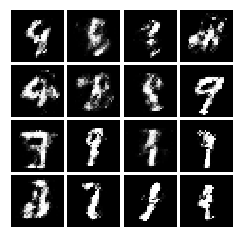

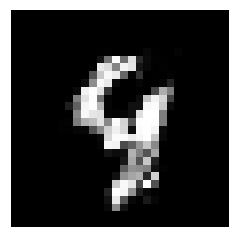

Epoch: 27/500
Iter: 33280/70000
Discriminator loss: 0.6901
Generator loss: 2.291

Epoch: 29/500
Iter: 21504/70000
Discriminator loss: 0.7897
Generator loss: 2.244



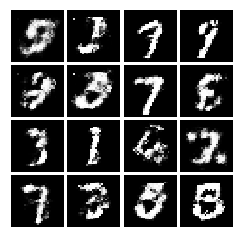

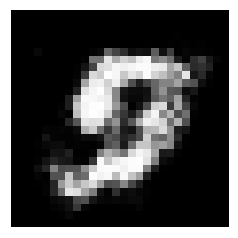

Epoch: 31/500
Iter: 9728/70000
Discriminator loss: 0.8111
Generator loss: 2.109

Epoch: 32/500
Iter: 67840/70000
Discriminator loss: 0.6543
Generator loss: 2.226

Epoch: 34/500
Iter: 56064/70000
Discriminator loss: 0.6449
Generator loss: 2.175



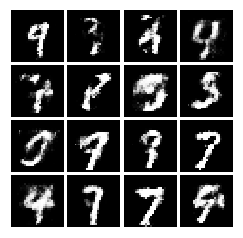

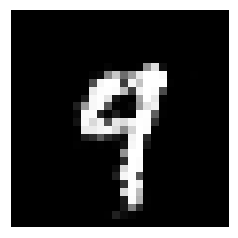

Epoch: 36/500
Iter: 44288/70000
Discriminator loss: 0.7638
Generator loss: 2.43

Epoch: 38/500
Iter: 32512/70000
Discriminator loss: 0.7204
Generator loss: 2.332

Epoch: 40/500
Iter: 20736/70000
Discriminator loss: 0.8627
Generator loss: 1.92



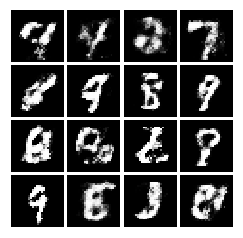

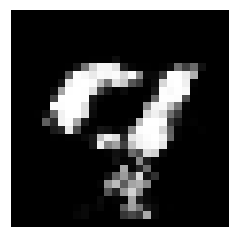

Epoch: 42/500
Iter: 8960/70000
Discriminator loss: 0.789
Generator loss: 1.912

Epoch: 43/500
Iter: 67072/70000
Discriminator loss: 0.8414
Generator loss: 2.061

Epoch: 45/500
Iter: 55296/70000
Discriminator loss: 0.8354
Generator loss: 2.514



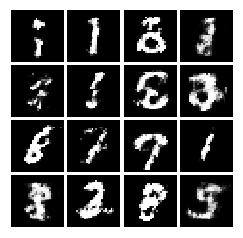

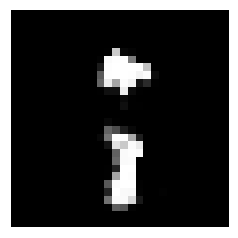

Epoch: 47/500
Iter: 43520/70000
Discriminator loss: 0.8467
Generator loss: 2.15

Epoch: 49/500
Iter: 31744/70000
Discriminator loss: 0.6377
Generator loss: 2.5



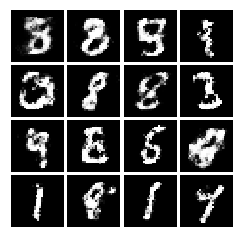

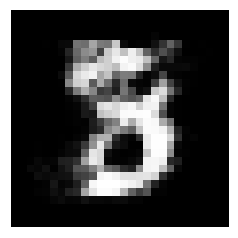

Epoch: 51/500
Iter: 19968/70000
Discriminator loss: 0.5091
Generator loss: 2.359

Epoch: 53/500
Iter: 8192/70000
Discriminator loss: 0.8143
Generator loss: 2.404

Epoch: 54/500
Iter: 66304/70000
Discriminator loss: 0.7372
Generator loss: 2.145



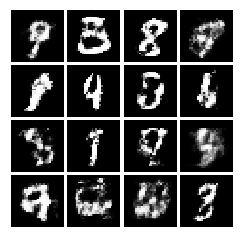

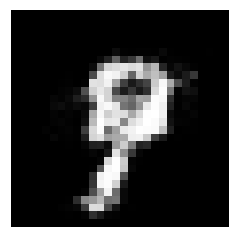

Epoch: 56/500
Iter: 54528/70000
Discriminator loss: 0.714
Generator loss: 2.05

Epoch: 58/500
Iter: 42752/70000
Discriminator loss: 0.9153
Generator loss: 2.024

Epoch: 60/500
Iter: 30976/70000
Discriminator loss: 0.7767
Generator loss: 2.275



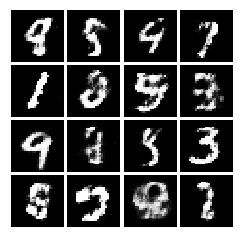

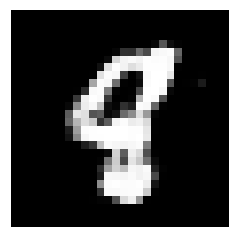

Epoch: 62/500
Iter: 19200/70000
Discriminator loss: 0.6743
Generator loss: 1.854

Epoch: 64/500
Iter: 7424/70000
Discriminator loss: 0.7898
Generator loss: 2.306

Epoch: 65/500
Iter: 65536/70000
Discriminator loss: 0.6917
Generator loss: 2.713



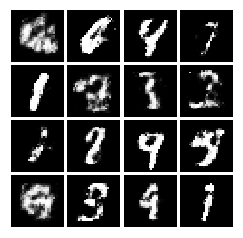

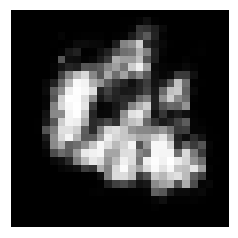

Epoch: 67/500
Iter: 53760/70000
Discriminator loss: 0.554
Generator loss: 2.276

Epoch: 69/500
Iter: 41984/70000
Discriminator loss: 0.6768
Generator loss: 2.222



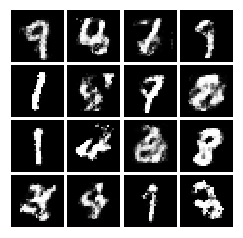

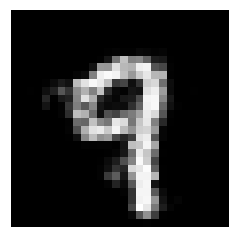

Epoch: 71/500
Iter: 30208/70000
Discriminator loss: 0.6908
Generator loss: 2.559

Epoch: 73/500
Iter: 18432/70000
Discriminator loss: 0.7317
Generator loss: 2.442

Epoch: 75/500
Iter: 6656/70000
Discriminator loss: 0.7417
Generator loss: 2.601



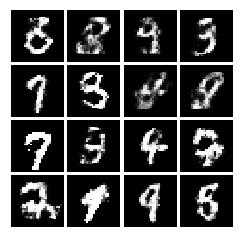

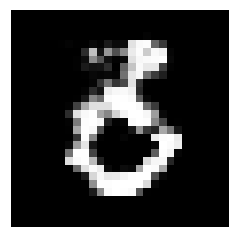

Epoch: 76/500
Iter: 64768/70000
Discriminator loss: 0.6852
Generator loss: 1.896

Epoch: 78/500
Iter: 52992/70000
Discriminator loss: 0.704
Generator loss: 2.53

Epoch: 80/500
Iter: 41216/70000
Discriminator loss: 0.7725
Generator loss: 2.306



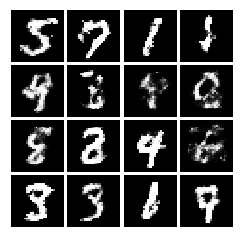

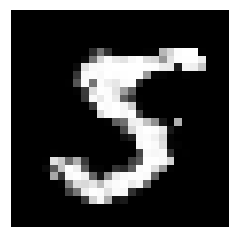

Epoch: 82/500
Iter: 29440/70000
Discriminator loss: 0.6751
Generator loss: 2.381

Epoch: 84/500
Iter: 17664/70000
Discriminator loss: 0.6753
Generator loss: 2.238



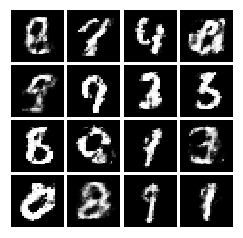

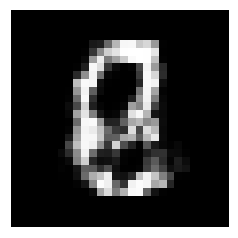

Epoch: 86/500
Iter: 5888/70000
Discriminator loss: 0.765
Generator loss: 2.539

Epoch: 87/500
Iter: 64000/70000
Discriminator loss: 0.6868
Generator loss: 2.338

Epoch: 89/500
Iter: 52224/70000
Discriminator loss: 0.6143
Generator loss: 2.534



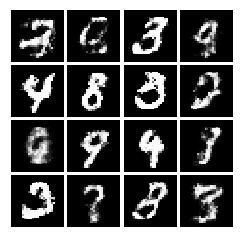

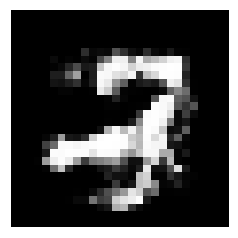

Epoch: 91/500
Iter: 40448/70000
Discriminator loss: 0.6977
Generator loss: 2.295

Epoch: 93/500
Iter: 28672/70000
Discriminator loss: 0.5178
Generator loss: 2.71

Epoch: 95/500
Iter: 16896/70000
Discriminator loss: 0.5312
Generator loss: 2.178



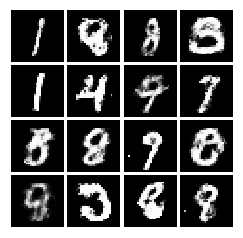

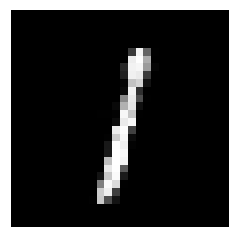

Epoch: 97/500
Iter: 5120/70000
Discriminator loss: 0.7496
Generator loss: 2.114

Epoch: 98/500
Iter: 63232/70000
Discriminator loss: 0.666
Generator loss: 2.483

Epoch: 100/500
Iter: 51456/70000
Discriminator loss: 0.6593
Generator loss: 2.49



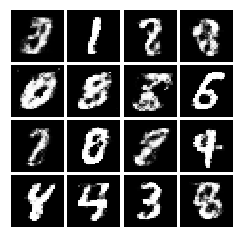

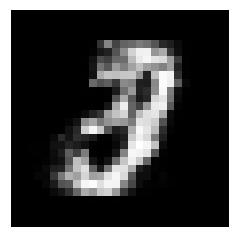

Epoch: 102/500
Iter: 39680/70000
Discriminator loss: 0.696
Generator loss: 2.285

Epoch: 104/500
Iter: 27904/70000
Discriminator loss: 0.7377
Generator loss: 2.113



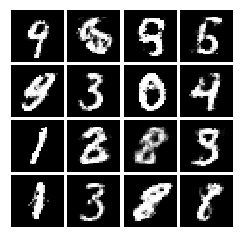

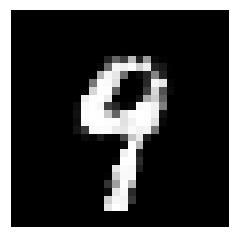

Epoch: 106/500
Iter: 16128/70000
Discriminator loss: 0.7401
Generator loss: 2.191

Epoch: 108/500
Iter: 4352/70000
Discriminator loss: 0.5424
Generator loss: 2.892

Epoch: 109/500
Iter: 62464/70000
Discriminator loss: 0.5435
Generator loss: 2.328



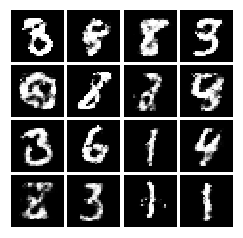

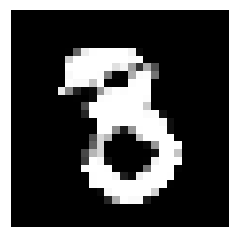

Epoch: 111/500
Iter: 50688/70000
Discriminator loss: 0.5873
Generator loss: 2.267

Epoch: 113/500
Iter: 38912/70000
Discriminator loss: 0.5256
Generator loss: 2.737

Epoch: 115/500
Iter: 27136/70000
Discriminator loss: 0.6152
Generator loss: 2.79



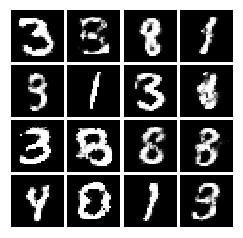

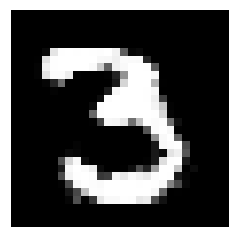

Epoch: 117/500
Iter: 15360/70000
Discriminator loss: 0.6209
Generator loss: 2.657

Epoch: 119/500
Iter: 3584/70000
Discriminator loss: 0.6782
Generator loss: 2.144

Epoch: 120/500
Iter: 61696/70000
Discriminator loss: 0.651
Generator loss: 2.401



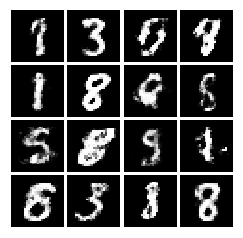

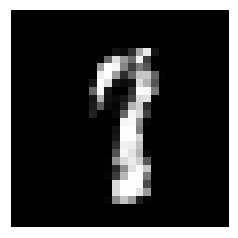

Epoch: 122/500
Iter: 49920/70000
Discriminator loss: 0.6053
Generator loss: 2.267

Epoch: 124/500
Iter: 38144/70000
Discriminator loss: 0.5899
Generator loss: 2.358



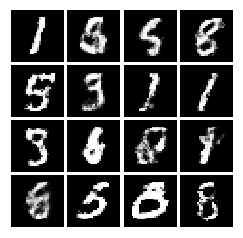

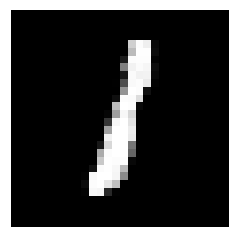

Epoch: 126/500
Iter: 26368/70000
Discriminator loss: 0.5113
Generator loss: 2.223

Epoch: 128/500
Iter: 14592/70000
Discriminator loss: 0.5657
Generator loss: 2.32

Epoch: 130/500
Iter: 2816/70000
Discriminator loss: 0.6482
Generator loss: 2.195



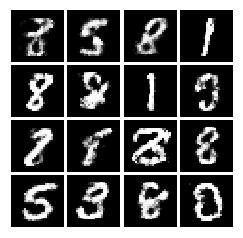

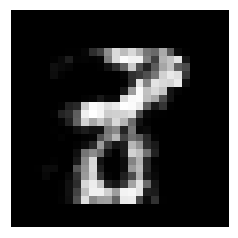

Epoch: 131/500
Iter: 60928/70000
Discriminator loss: 0.5556
Generator loss: 2.285

Epoch: 133/500
Iter: 49152/70000
Discriminator loss: 0.6284
Generator loss: 2.277

Epoch: 135/500
Iter: 37376/70000
Discriminator loss: 0.6263
Generator loss: 2.22



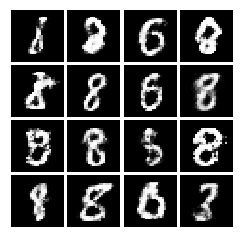

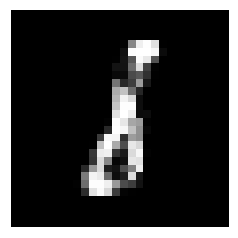

Epoch: 137/500
Iter: 25600/70000
Discriminator loss: 0.575
Generator loss: 2.363

Epoch: 139/500
Iter: 13824/70000
Discriminator loss: 0.6032
Generator loss: 2.108



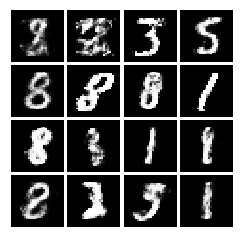

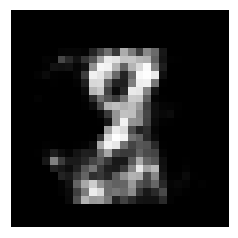

Epoch: 141/500
Iter: 2048/70000
Discriminator loss: 0.5544
Generator loss: 2.621

Epoch: 142/500
Iter: 60160/70000
Discriminator loss: 0.645
Generator loss: 2.051

Epoch: 144/500
Iter: 48384/70000
Discriminator loss: 0.4548
Generator loss: 2.595



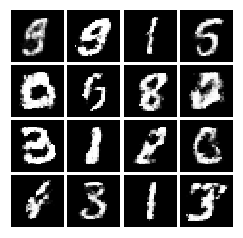

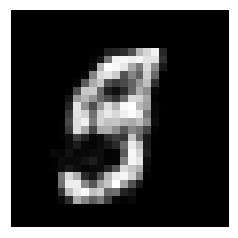

Epoch: 146/500
Iter: 36608/70000
Discriminator loss: 0.5056
Generator loss: 2.526

Epoch: 148/500
Iter: 24832/70000
Discriminator loss: 0.6684
Generator loss: 2.116

Epoch: 150/500
Iter: 13056/70000
Discriminator loss: 0.5269
Generator loss: 2.617



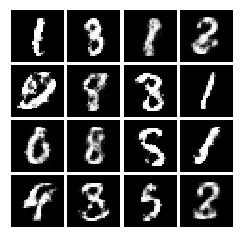

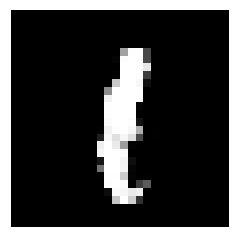

Epoch: 152/500
Iter: 1280/70000
Discriminator loss: 0.4177
Generator loss: 2.586

Epoch: 153/500
Iter: 59392/70000
Discriminator loss: 0.6506
Generator loss: 2.464

Epoch: 155/500
Iter: 47616/70000
Discriminator loss: 0.5792
Generator loss: 2.573



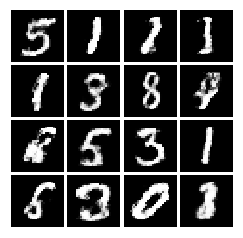

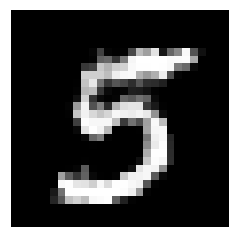

Epoch: 157/500
Iter: 35840/70000
Discriminator loss: 0.5163
Generator loss: 2.31

Epoch: 159/500
Iter: 24064/70000
Discriminator loss: 0.5032
Generator loss: 2.33



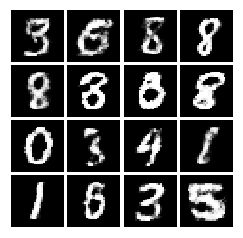

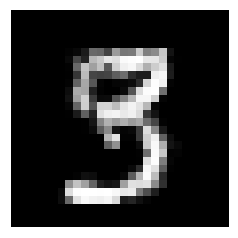

Epoch: 161/500
Iter: 12288/70000
Discriminator loss: 0.6654
Generator loss: 2.676

Epoch: 163/500
Iter: 512/70000
Discriminator loss: 0.6094
Generator loss: 2.398

Epoch: 164/500
Iter: 58624/70000
Discriminator loss: 0.5974
Generator loss: 2.082



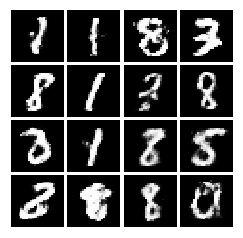

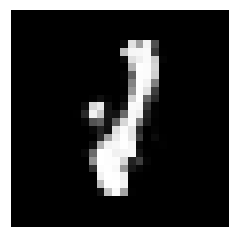

Epoch: 166/500
Iter: 46848/70000
Discriminator loss: 0.5919
Generator loss: 2.322

Epoch: 168/500
Iter: 35072/70000
Discriminator loss: 0.5956
Generator loss: 2.444

Epoch: 170/500
Iter: 23296/70000
Discriminator loss: 0.5299
Generator loss: 2.51



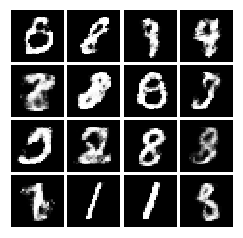

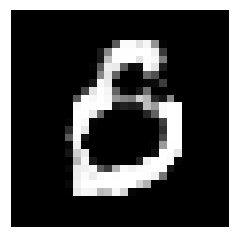

Epoch: 172/500
Iter: 11520/70000
Discriminator loss: 0.5833
Generator loss: 2.013

Epoch: 173/500
Iter: 69632/70000
Discriminator loss: 0.5202
Generator loss: 2.239

Epoch: 175/500
Iter: 57856/70000
Discriminator loss: 0.5904
Generator loss: 2.95



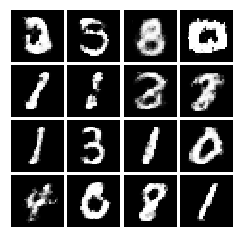

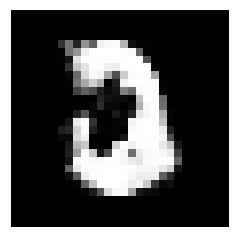

Epoch: 177/500
Iter: 46080/70000
Discriminator loss: 0.517
Generator loss: 2.87

Epoch: 179/500
Iter: 34304/70000
Discriminator loss: 0.5731
Generator loss: 2.947



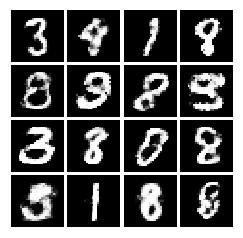

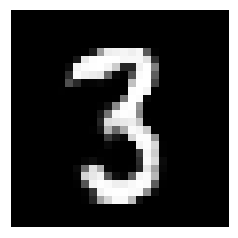

Epoch: 181/500
Iter: 22528/70000
Discriminator loss: 0.5241
Generator loss: 2.75

Epoch: 183/500
Iter: 10752/70000
Discriminator loss: 0.5662
Generator loss: 2.894

Epoch: 184/500
Iter: 68864/70000
Discriminator loss: 0.5103
Generator loss: 2.437



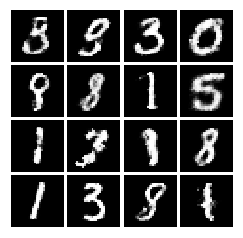

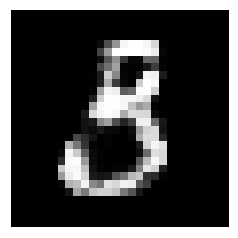

Epoch: 186/500
Iter: 57088/70000
Discriminator loss: 0.5571
Generator loss: 2.725

Epoch: 188/500
Iter: 45312/70000
Discriminator loss: 0.4965
Generator loss: 2.142

Epoch: 190/500
Iter: 33536/70000
Discriminator loss: 0.5878
Generator loss: 2.547



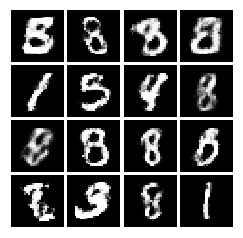

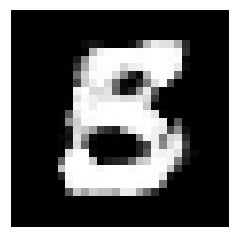

Epoch: 192/500
Iter: 21760/70000
Discriminator loss: 0.551
Generator loss: 2.344

Epoch: 194/500
Iter: 9984/70000
Discriminator loss: 0.5679
Generator loss: 2.591

Epoch: 195/500
Iter: 68096/70000
Discriminator loss: 0.6181
Generator loss: 2.522



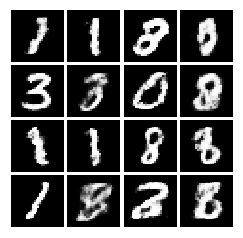

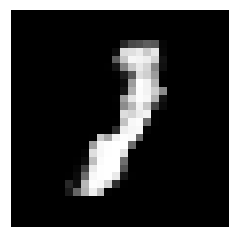

Epoch: 197/500
Iter: 56320/70000
Discriminator loss: 0.6473
Generator loss: 2.263

Epoch: 199/500
Iter: 44544/70000
Discriminator loss: 0.5843
Generator loss: 3.028



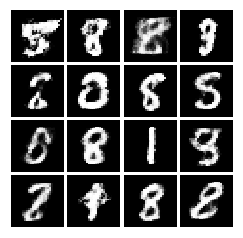

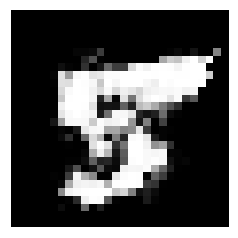

Epoch: 201/500
Iter: 32768/70000
Discriminator loss: 0.6768
Generator loss: 2.298

Epoch: 203/500
Iter: 20992/70000
Discriminator loss: 0.5143
Generator loss: 2.633

Epoch: 205/500
Iter: 9216/70000
Discriminator loss: 0.524
Generator loss: 2.638



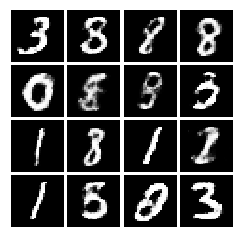

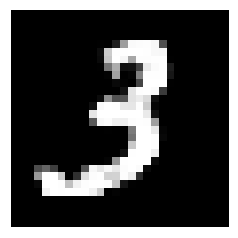

Epoch: 206/500
Iter: 67328/70000
Discriminator loss: 0.4536
Generator loss: 2.663



KeyboardInterrupt: 

In [37]:
minibatch_counter = 0
epoch_counter = 0

d_losses = []
g_losses = []

with tf.device("/gpu:0"), tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    if restore:
        saver.restore(sess, os.path.join(model_save_folder, checkpoint))
        print("Restored model:", checkpoint, "from:", model_save_folder)
                      
    while epoch_counter < num_epoch:
            
        new_epoch, X_mb = mnist.next_batch(minibatch_size)

        _, D_loss_curr = sess.run([D_solver, D_loss], 
                                  feed_dict={
                                      X: X_mb, 
                                      Z: sample_Z(minibatch_size, random_sample_dim)
                                    })
                      
        _, G_loss_curr = sess.run([G_solver, G_loss], 
                                  feed_dict={
                                      Z: sample_Z(minibatch_size, random_sample_dim)
                                  })

        # Plotting and saving images and the model
        if new_epoch and epoch_counter % plot_every_epochs == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, random_sample_dim)})

            fig = util.plot(samples)
            figname = '{}.png'.format(str(minibatch_counter).zfill(3))
            plt.savefig(os.path.join(image_save_folder, figname), bbox_inches='tight')
            plt.show()
            plt.close(fig)
            
            im = util.plot_single(samples[0], epoch_counter)
            plt.savefig(os.path.join(image_save_folder, 'single_' + figname), bbox_inches='tight')
            plt.show()
            
            chkpname = "fc_2layer_e{}_{:.3f}.ckpt".format(epoch_counter, G_loss_curr)
            saver.save(sess, os.path.join(model_save_folder, chkpname))

        # Printing runtime statistics
        if minibatch_counter % print_every_batches == 0:
            print('Epoch: {}/{}'.format(epoch_counter, num_epoch))
            print('Iter: {}/{}'.format(mnist.position_in_epoch, mnist.n))
            print('Discriminator loss: {:.4}'. format(D_loss_curr))
            print('Generator loss: {:.4}'.format(G_loss_curr))
            print()
        
        # Bookkeeping
        minibatch_counter += 1
        if new_epoch:
            epoch_counter += 1
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
        
    chkpname = "fc_2layer_e{}_{:.3f}.ckpt".format(epoch_counter, G_loss_curr)
    saver.save(sess, os.path.join(model_save_folder, chkpname))

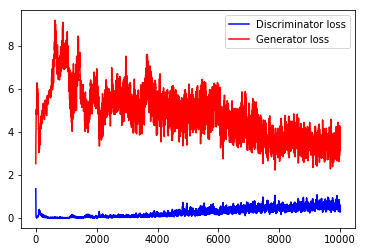

In [38]:
disc_line, = plt.plot(range(len(d_losses[:10000])), d_losses[:10000], c='b', label="Discriminator loss")
gen_line, = plt.plot(range(len(d_losses[:10000])), g_losses[:10000], c='r', label="Generator loss")
plt.legend([disc_line, gen_line], ["Discriminator loss", "Generator loss"])

### Mode collapse

<center>
<img src="data/img/mode_collapse.png">
<img src="data/img/mode_collapse_2.png">

Example of mode collapse in a GAN
</center>

Second image is from: Reed, S., van den Oord, A., Kalchbrenner, N., Bapst, V., Botvinick, M., & de Freitas, N. (2016). [Generating interpretable images with controllable structure](https://pdfs.semanticscholar.org/0365/da7fabc8fcc453432a94237814db3da04af2.pdf).

### Further reading

- https://github.com/hwalsuklee/tensorflow-generative-model-collections

- https://github.com/wiseodd/generative-models/

- https://github.com/znxlwm/pytorch-generative-model-collections